# Trabajando con los dark frames
Para combinar los dark frames, debemos primero decidir si:

* Restar el overscan
* Recortar las imágenes
* Corregir por bias

## Importando los módulos

In [1]:
from pathlib import Path
from ccdproc import ImageFileCollection, CCDData, subtract_overscan, trim_image, combine

from astropy.stats import mad_std
import matplotlib.pyplot as plt
import numpy as np
from functions import show_image

Definimos las rutas a los archivos en los que trabajaremos

In [2]:
#- Define la ruta a los datos "crudos" y las selecciona
cryo_path = Path('example-cryo-LFC')
files = ImageFileCollection(cryo_path)

#- Crea una colección de imágenes dark
lfc_darks_raw = ImageFileCollection(cryo_path / 'darks')

#- Define la ruta de las imágenes calibradas
calibrated_data = Path('example-reduced')

#- Selecciona las imágenes calibradas
reduced_images = ImageFileCollection(calibrated_data)

In [3]:
files.summary

file,simple,bitpix,naxis,naxis1,naxis2,bscale,bzero,date,origin,latitude,longitud,telescop,fratio,instrume,detector,frame,ccdpicno,object,imagetyp,exptime,darktime,date-obs,ut,jd,ra,dec,equinox,epoch,ha,st,airmass,filter,gain,secpix1,secpix2,ccdbin1,ccdbin2,rotangle,datasec,ccdsec,biassec,loginfo,chipid
str14,bool,int64,int64,int64,int64,float64,float64,str10,str34,float64,float64,str17,float64,str3,str14,int64,int64,str7,str9,float64,float64,str10,str12,float64,str12,str12,float64,float64,str12,str12,float64,str2,float64,float64,float64,int64,int64,float64,str15,str15,str18,str18,int64
ccd.001.0.fits,True,16,2,2080,4128,1.0,32768.0,2016-01-15,California Institute of Technology,33.4,-116.9,Hale 5m Telescope,7.5,LFC,SITe SI002 x 6,1,1,bias,BIAS,0.0,0.12,2016-01-15,23:53:30.00,2457403.495486,23:44:32.40,33:22:10.80,2000.0,2000.0,00:00:04.00,23:45:23.10,1.0,i',1.1,0.182,0.182,1,1,0.0,"[1:2048,1:4128]","[1:2048,1:4128]","[2049:2080,1:4127]",Status=0x00000000,0
ccd.002.0.fits,True,16,2,2080,4128,1.0,32768.0,2016-01-15,California Institute of Technology,33.4,-116.9,Hale 5m Telescope,7.5,LFC,SITe SI002 x 6,2,2,bias,BIAS,0.0,0.111,2016-01-15,23:55:29.00,2457403.496863,23:46:30.51,33:22:10.60,2000.0,2000.0,00:00:04.00,23:47:22.43,1.0,i',1.1,0.182,0.182,1,1,0.0,"[1:2048,1:4128]","[1:2048,1:4128]","[2049:2080,1:4127]",Status=0x00000000,0
ccd.003.0.fits,True,16,2,2080,4128,1.0,32768.0,2016-01-15,California Institute of Technology,33.4,-116.9,Hale 5m Telescope,7.5,LFC,SITe SI002 x 6,3,3,bias,BIAS,0.0,0.112,2016-01-15,23:57:27.00,2457403.498229,23:48:29.06,33:22:10.50,2000.0,2000.0,00:00:04.00,23:49:20.75,1.0,i',1.1,0.182,0.182,1,1,0.0,"[1:2048,1:4128]","[1:2048,1:4128]","[2049:2080,1:4127]",Status=0x00000000,0
ccd.004.0.fits,True,16,2,2080,4128,1.0,32768.0,2016-01-16,California Institute of Technology,33.4,-116.9,Hale 5m Telescope,7.5,LFC,SITe SI002 x 6,4,4,bias,BIAS,0.0,0.12,2016-01-15,23:59:25.00,2457403.499595,23:50:27.42,33:22:10.39,2000.0,2000.0,00:00:04.00,23:51:19.07,1.0,i',1.1,0.182,0.182,1,1,0.0,"[1:2048,1:4128]","[1:2048,1:4128]","[2049:2080,1:4127]",Status=0x00000000,0
ccd.005.0.fits,True,16,2,2080,4128,1.0,32768.0,2016-01-16,California Institute of Technology,33.4,-116.9,Hale 5m Telescope,7.5,LFC,SITe SI002 x 6,5,5,bias,BIAS,0.0,0.12,2016-01-16,00:01:23.00,2457403.500961,23:52:25.69,33:22:10.39,2000.0,2000.0,00:00:04.00,23:53:17.40,1.0,i',1.1,0.182,0.182,1,1,0.0,"[1:2048,1:4128]","[1:2048,1:4128]","[2049:2080,1:4127]",Status=0x00000000,0
ccd.006.0.fits,True,16,2,2080,4128,1.0,32768.0,2016-01-16,California Institute of Technology,33.4,-116.9,Hale 5m Telescope,7.5,LFC,SITe SI002 x 6,6,6,bias,BIAS,0.0,0.112,2016-01-16,00:03:21.00,2457403.502326,23:54:23.73,33:22:10.30,2000.0,2000.0,00:00:04.00,23:55:15.72,1.0,i',1.1,0.182,0.182,1,1,0.0,"[1:2048,1:4128]","[1:2048,1:4128]","[2049:2080,1:4127]",Status=0x00000000,0
ccd.014.0.fits,True,16,2,2080,4128,1.0,32768.0,2016-01-16,California Institute of Technology,33.4,-116.9,Hale 5m Telescope,7.5,LFC,SITe SI002 x 6,14,14,flat_g,FLATFIELD,70.001,70.673,2016-01-16,04:17:28.00,2457403.678796,04:08:58.50,33:25:12.69,2000.0,2000.0,00:00:04.00,04:10:04.46,1.0,g',1.1,0.182,0.182,1,1,0.0,"[1:2048,1:4128]","[1:2048,1:4128]","[2049:2080,1:4127]",Status=0x00000000,0
ccd.015.0.fits,True,16,2,2080,4128,1.0,32768.0,2016-01-16,California Institute of Technology,33.4,-116.9,Hale 5m Telescope,7.5,LFC,SITe SI002 x 6,15,15,flat_g,FLATFIELD,70.011,70.683,2016-01-16,04:20:35.00,2457403.680961,04:12:05.19,33:25:16.79,2000.0,2000.0,00:00:04.00,04:13:11.98,1.0,g',1.1,0.182,0.182,1,1,0.0,"[1:2048,1:4128]","[1:2048,1:4128]","[2049:2080,1:4127]",Status=0x00000000,0
ccd.016.0.fits,True,16,2,2080,4128,1.0,32768.0,2016-01-16,California Institute of Technology,33.4,-116.9,Hale 5m Telescope,7.5,LFC,SITe SI002 x 6,16,16,flat_g,FLATFIELD,70.001,70.684,2016-01-16,04:23:41.00,2457403.683113,04:15:12.00,33:25:20.79,2000.0,2000.0,00:00:04.00,04:16:18.49,1.0,g',1.1,0.182,0.182,1,1,0.0,"[1:2048,1:4128]","[1:2048,1:4128]","[2049:20

Como habíamos visto anteriormente, los tiempos de exposición de las imágenes DARK son iguales a los tiempos de exposición de las imágenes de OBJETO y de FLATFIELD.

No es necesario corregir por bias porque no se necesita reescalar. Pero sí haremos lo siguiente:

* Restar el overscan
* Recortar las imágenes


In [4]:
for ccd, file_name in lfc_darks_raw.ccds(imagetyp='DARK',            
                                         ccd_kwargs={'unit': 'adu'},
                                         return_fname=True           
                                        ):    
    # Subtract the overscan
    ccd = subtract_overscan(ccd, overscan=ccd[:, 2055:], median=True)
    
    # Trim the overscan
    ccd = trim_image(ccd[:, :2048])
    
    # Save the result
    ccd.write(calibrated_data / file_name, overwrite=True)

Actualicemos la colección de imágenes y veamos sus propiedades

In [5]:
reduced_images.refresh()

reduced_images.summary['file', 'imagetyp', 'exptime', 'filter', 'combined']

file,imagetyp,exptime,filter,combined
str19,str9,float64,str2,object
ccd.001.0.fits,BIAS,0.0,i',--
ccd.002.0.fits,BIAS,0.0,i',--
ccd.003.0.fits,BIAS,0.0,i',--
ccd.004.0.fits,BIAS,0.0,i',--
ccd.005.0.fits,BIAS,0.0,i',--
ccd.006.0.fits,BIAS,0.0,i',--
ccd.013.0.fits,DARK,300.0,r',--
ccd.014.0.fits,DARK,300.0,r',--
ccd.015.0.fits,DARK,300.0,r',--


# Combinando los dark frames
## Combinando para cada tiempo de exposición

In [6]:
darks = reduced_images.summary['imagetyp'] == 'DARK'

dark_times = set(reduced_images.summary['exptime'][darks])

print(dark_times)

{300.0, 70.0, 7.0}


Usamos un ciclo for que itera sobre cada tiempo de exposición y luego:

* Selecciona todas las imágenes dark para el tiempo de exposición dado
* Combina esas imágenes dark
* Actualiza su información
* Guarda los archivos combinados

In [7]:
for exp_time in sorted(dark_times):

    #- Selecciona las imágenes dark dentro de la carpeta
    calibrated_darks = reduced_images.files_filtered(imagetyp='dark',
                                                         exptime=exp_time,
                                                         include_path=True)

    #- Combina las imágenes
    combined_dark = combine(calibrated_darks,
                                 method='average',
                                 sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                                 sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std,
                                 mem_limit=350e6
                                )

    #- Actualiza la información
    combined_dark.meta['combined'] = True

    #- Guarda los archivos
    dark_file_name = 'combined_dark_{:6.3f}.fits'.format(exp_time)
    combined_dark.write(calibrated_data / dark_file_name)

INFO:astropy:splitting each image into 4 chunks to limit memory usage to 350000000.0 bytes.


INFO: splitting each image into 4 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]


INFO:astropy:splitting each image into 4 chunks to limit memory usage to 350000000.0 bytes.


INFO: splitting each image into 4 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]


INFO:astropy:splitting each image into 4 chunks to limit memory usage to 350000000.0 bytes.


INFO: splitting each image into 4 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]


# Visualizando el archivo combinado de imágenes DARK


Text(0.5, 1.0, '3 dark images combined')

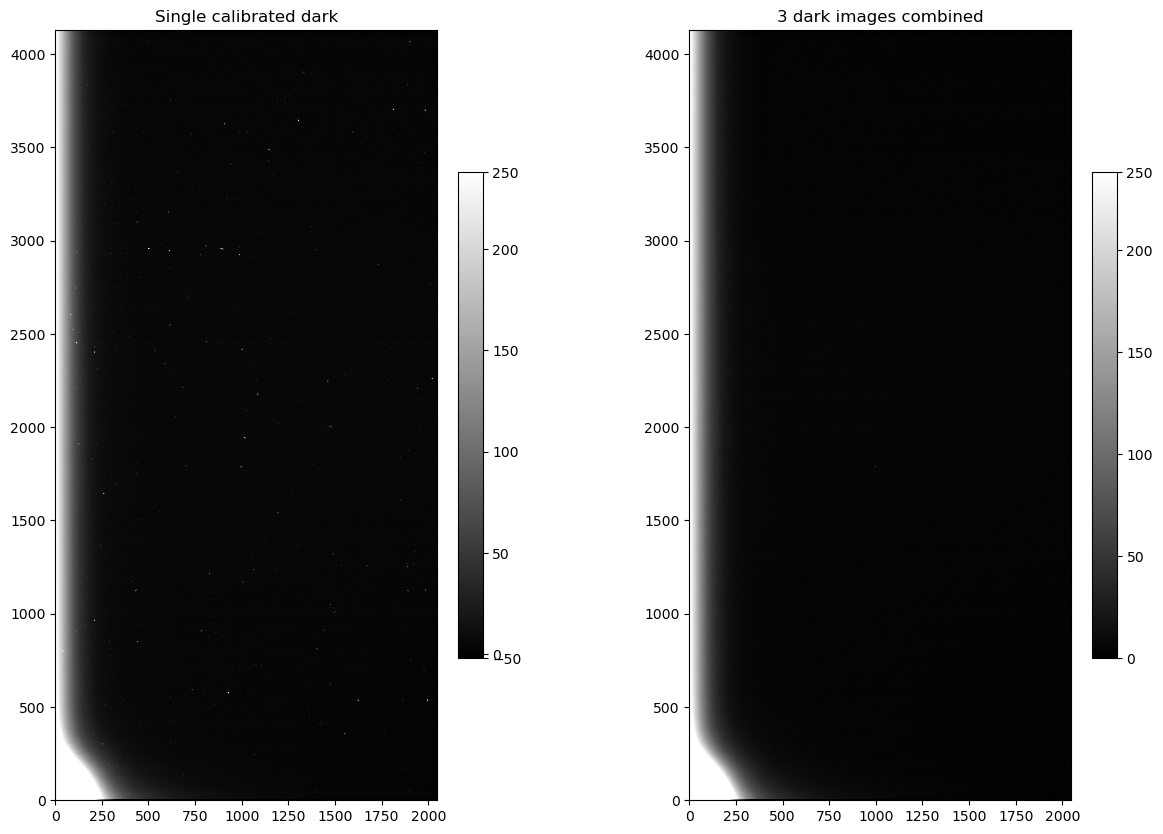

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))

show_image(CCDData.read(calibrated_darks[0]).data, cmap='gray', ax=ax1, fig=fig)
ax1.set_title('Single calibrated dark')
show_image(combined_dark.data, cmap='gray', ax=ax2, fig=fig)
ax2.set_title('{} dark images combined'.format(len(calibrated_darks)))